In [1]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
from tqdm import tqdm

#use for naive_bayes
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,SnowballStemmer
from nltk.tokenize import TweetTokenizer
import pdb
from nltk.corpus import twitter_samples
import numpy as np
import pandas as pd
import nltk
from os import getcwd

from tensorflow.keras import layers
from tensorflow.keras import losses

nltk.download('stopwords')

#use for LSTM and WordEmbedding Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from  nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Big_Data/custom_model/"
train_x = np.load(path + 'train_x.npz') 
train_y = np.load(path + 'train_y.npz')
test_x = np.load(path + 'test_x.npz')
test_y = np.load(path + 'test_y.npz')

In [4]:
train_x = np.array(train_x['arr_0'])
train_y = np.array(train_y['arr_0'])
test_x = np.array(test_x['arr_0'])
test_y = np.array(test_y['arr_0'])

In [ ]:
# %cd "/content/drive/MyDrive/Big_Data/custom_model"
# np.savez_compressed('train_x.npz',train_x)
# np.savez_compressed('train_y.npz',train_y)
# np.savez_compressed('test_x.npz',test_x)
# np.savez_compressed('test_y.npz',test_y)

/content/drive/MyDrive/Big_Data/custom_model


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)

x_train = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen = 250)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen = 250)

#create y_data
encoder = LabelEncoder()
encoder.fit(train_y)

y_train = encoder.transform(train_y)
y_test = encoder.transform(test_y)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [5]:
%cd "/content/drive/MyDrive/Big_Data/custom_model"
 
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove/glove.6B.50d.txt')

/content/drive/MyDrive/Big_Data/custom_model


In [6]:
def pretrained_embedding_layer(word_to_vec_map,word_to_index): 
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]
    vocab_size = len(word_to_index) + 1

    #Initialize the embedding matrix
    emb_matrix = np.zeros((vocab_size, emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx,:] = word_to_vec_map[word]
    embedding_layer = Embedding(vocab_size,emb_dim, input_length=250, trainable = False)
    embedding_layer.build((None,))        

    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

embedding_layer = pretrained_embedding_layer(word_to_vec_map,word_to_index)

In [7]:
sequence_input = tf.keras.layers.Input(shape = (250,),dtype = 'int32')
embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [2,3,4,5,6]
for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters = 200,
                                    kernel_size = filter_size,
                                    activation = 'relu')(embedded_sequences)
    l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)                                   
    convs.append(l_pool)

l_merge = tf.keras.layers.concatenate(convs,axis = 1)
x = tf.keras.layers.Dropout(0.5)(l_merge)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)

model_CNN = Model(sequence_input,outputs)

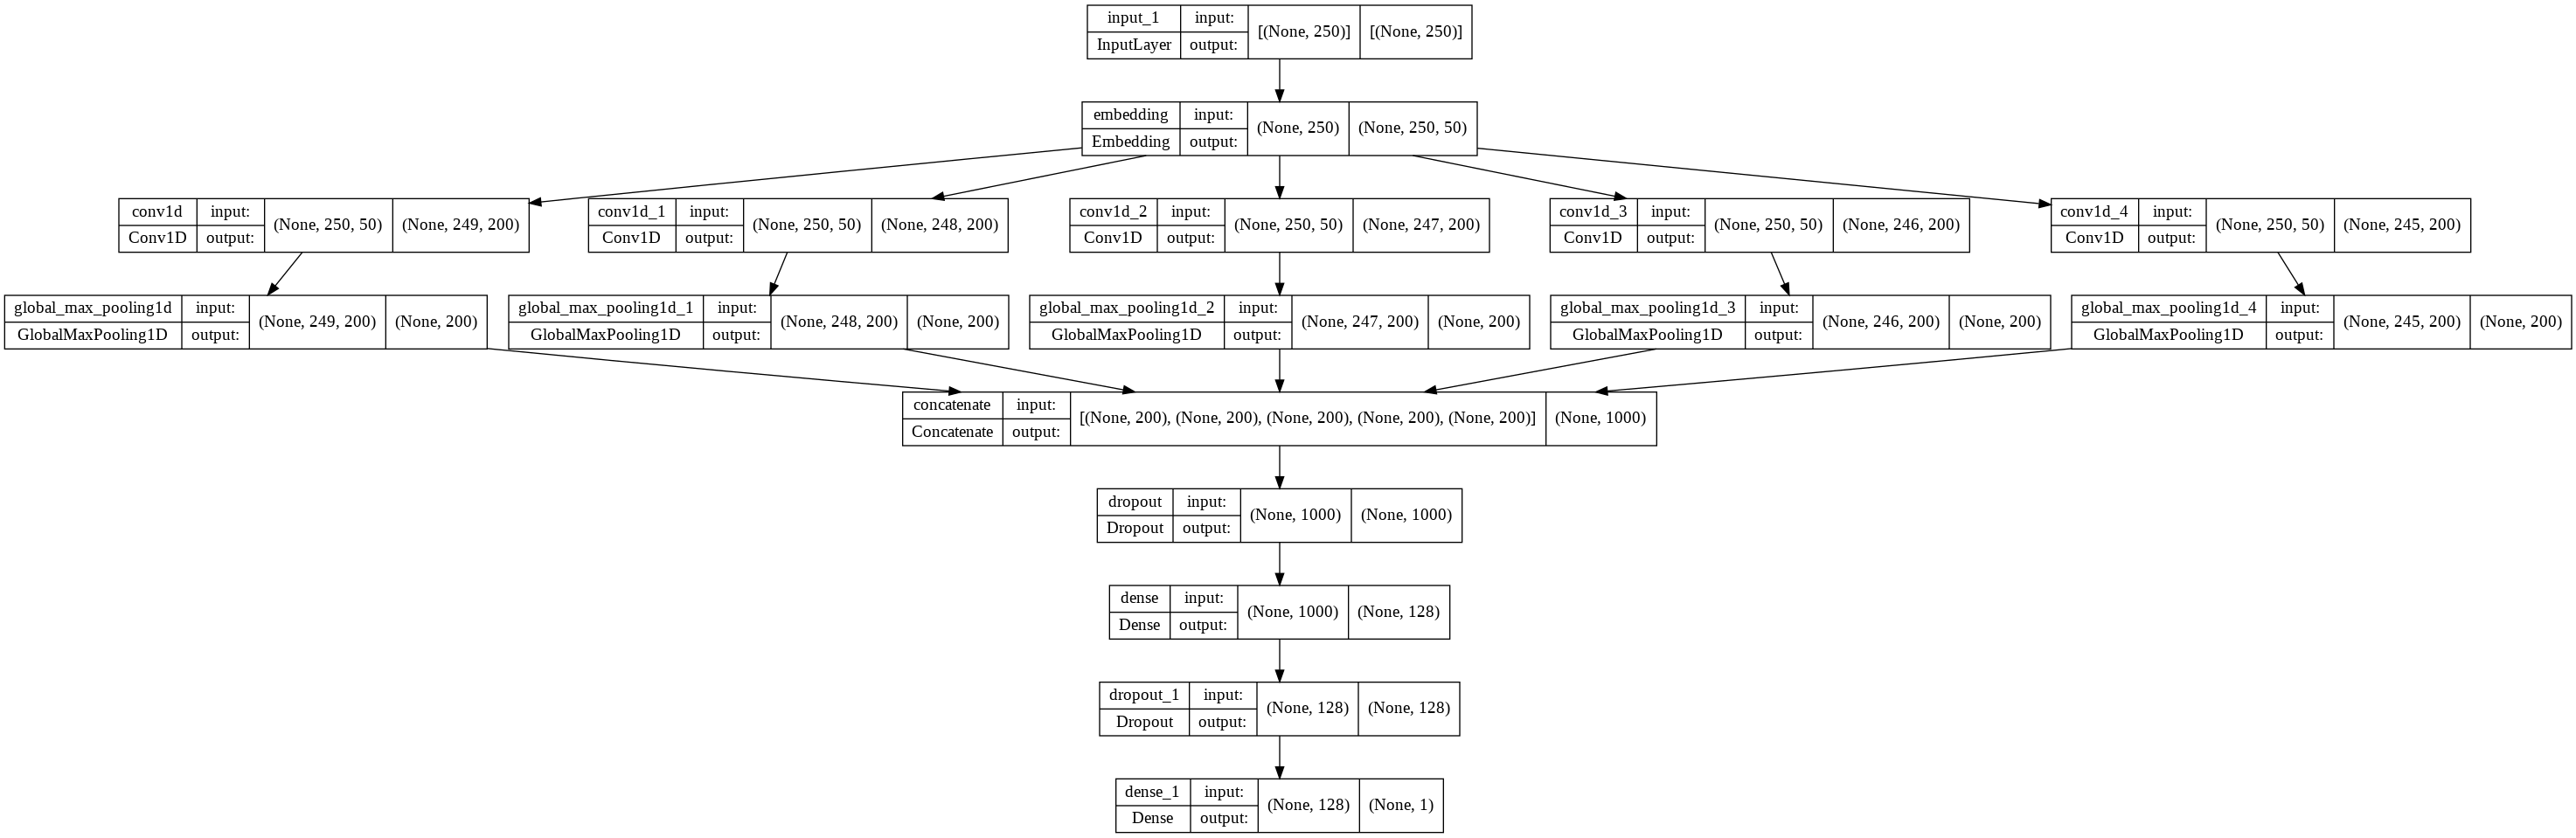

In [13]:
tf.keras.utils.plot_model(model_CNN,show_shapes = True)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Big_Data/custom_model/training_CNN/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq = 1013 * 2)

model_CNN.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
model_CNN.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [ ]:
history = model_CNN.fit(
    x_train,
    y_train,
    epochs = 30,
    validation_split = 0.1,
    verbose = 1,
    shuffle = True,
    callbacks=[cp_callback]
)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


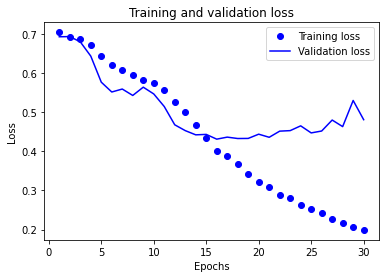

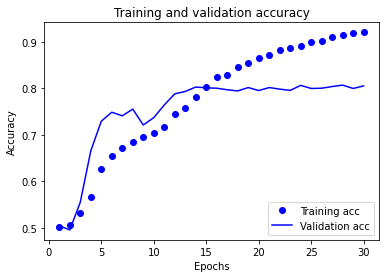

In [ ]:
history_dict = history.history

print(history_dict.keys())

#visualization
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#Training and validation loss
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#training and validataion accuray
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
!cd "/content/drive/MyDrive/Big_Data/custom_model/" 
!mkdir -p saved_model

model_CNN.save('saved_model/my_model_CNN')

INFO:tensorflow:Assets written to: saved_model/my_model_CNN/assets


In [ ]:
model_CNN.evaluate(x_test,y_test)

282/282 [==============================] - 3s 9ms/step - loss: 0.4470 - accuracy: 0.8100


[0.4469722509384155, 0.8100000023841858]

In [ ]:
def predict(sentence):
    lst = np.array([sentence])
    x = pad_sequences(tokenizer.texts_to_sequences(lst), maxlen = 250)
    a = model_CNN.predict(x)[0][0]
    
    if a >= 0.5:
       return "positive"
    return "negative"

In [ ]:
sentence = "hey you are terrible and i don't want you"
predict(sentence)

'negative'

In [ ]:
sentence = "happy birthday, you are my everything"
predict(sentence)

'positive'